In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from scipy.ndimage import gaussian_filter
import sys
from tqdm import tqdm
from functools import partial
import acd
from copy import deepcopy
sys.path.append('..')
from transforms_torch import bandpass_filter
plt.style.use('dark_background')
sys.path.append('../../dsets/mnist')
import dset
from model import Net, Net2c
from util import *
from numpy.fft import *
from torch import nn
from style import *
from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)
import pickle as pkl
from torchvision import datasets, transforms
from sklearn.decomposition import NMF
import transform_wrappers
import visualize as viz

In [7]:
im_torch, im_orig, label = dset.get_im_and_label(251, device=device) # this will download the mnist dataset
model = Net().to(device)
im_torch = im_torch.to(device)
model.load_state_dict(torch.load('../../dsets/mnist/mnist.model', map_location=device))
model = model.eval().to(device)

# fit/load nmf

In [41]:
mnist = datasets.MNIST('mnist/data', train=True, download=True)
X = mnist.data.numpy().astype(np.float32)
X = X.reshape(X.shape[0], -1)
Y = mnist.targets.numpy()

In [ ]:
plt.imshow(X[0])

In [36]:
nmf = NMF(n_components=30, random_state=42)
# nmf.fit(X)
# pkl.dump(nmf, open('nmf_30.pkl', 'wb'))
nmf = pkl.load(open('nmf_30.pkl', 'rb'))
print('D.shape', D.shape)

D.shape (30, 28, 28)


In [ ]:
D = nmf.components_.reshape(-1, 28, 28)
viz.viz_basis(D)

In [6]:
# calc err
X_t = nmf.transform(X) # (n, num_bases)
D = nmf.components_ # (num_bases, input_size)
X_ = X_t @ D.astype(np.float32) # inverse transform
np.mean(np.square(X_ - X)) / np.mean(np.square(X))

0.2155938798355274

# score nmf basis

In [45]:
transform = transform_wrappers.lay_from_w(D)
norm = transform_wrappers.NormLayer(mu=0.1307, std=0.3081)
reshape = transform_wrappers.ReshapeLayer(shape=(1, 28, 28))
net = transform_wrappers.Net_with_transform(model, transform=transform, norm=norm, reshape=reshape).to(device)
# print(list(net.modules()))

In [31]:
x = X[:1]
x_t = nmf.transform(x)
x_t_tensor = torch.Tensor(x_t).to(device)

# x.requires_grad = False
sweep_dim = 1
tiles = acd.tiling_2d.gen_tiles(x_t, fill=0, method='cd', sweep_dim=sweep_dim)
print('tiles.shape', tiles.shape, x_t_tensor.shape)
cd_scores_im = acd.get_scores_2d(net, method='cd', ims=tiles, im_torch=x_t_tensor, device='cuda')

 30%|███       | 9/30 [00:00<00:00, 82.07it/s]

tiles.shape (30, 1, 30) torch.Size([1, 30])


100%|██████████| 30/30 [00:00<00:00, 81.94it/s]


In [27]:
cd_scores_im.shape

(30, 10)

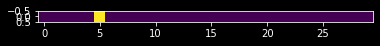

In [104]:
plt.imshow(tiles[5])